# Backdoor v3: Unemployment Risk Ratio

In [1]:
import sys
sys.path.append("../")

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from utils.backdoor_utils import backdoor_classifier
from utils.bootstrap import bootstrap_experiment

In [3]:
lalonde_exp = pd.read_csv("../data/lalonde_exp.csv")
lalonde_obs = pd.read_csv("../data/lalonde_psid.csv")

In [4]:
lalonde_exp["u78"] = lalonde_exp["re78"].apply(lambda x: 1 if x == 0 else 0)
lalonde_obs["u78"] = lalonde_obs["re78"].apply(lambda x: 1 if x == 0 else 0)

## Naive Estimate

In [5]:
lalonde_exp.loc[lalonde_exp["treat"] == 1, "u78"].mean() / lalonde_exp.loc[
    lalonde_exp["treat"] == 0, "u78"
].mean()

0.6874265569917744

We're now trying to compute the causal risk ratio:

$\beta = \frac{E[U_{78}^{a=1}]}{E[U_{78}^{a=0}]}$

Where $U_{78}$ represents a binary outcome of unemployment in the year 1978.

## Using a Classifier

### Experimental Data

In [6]:
backdoor_result = backdoor_classifier(
    lalonde_exp,
    "treat",
    "u78",
    ["age", "education", "black", "hispanic", "married", "u74", "u75"],
    "LogisticRegression",
)
print(f"The risk ratio is {backdoor_result:.2f}")

The risk ratio is 0.40


In [7]:
backdoor_result = backdoor_classifier(
    lalonde_exp,
    "treat",
    "u78",
    ["age", "education", "black", "hispanic", "married", "u74", "u75"],
    "DecisionTree",
)
print(f"The risk ratio is {backdoor_result:.2f}")

The risk ratio is 0.75


We're using a decision tree as it fits out model better.

In [8]:
backdoor_boostrap_results = bootstrap_experiment(
    df=lalonde_exp,
    function=backdoor_classifier,
    num_exp=10,
    n=50,
    ci=95,
    treatment_col="treat",
    outcome_col="u78",
    confounder_cols=[
        "age",
        "education",
        "black",
        "hispanic",
        "married",
        "u74",
        "u75",
    ],
    classifier_name="DecisionTree",
)

Running experiments: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.74it/s]


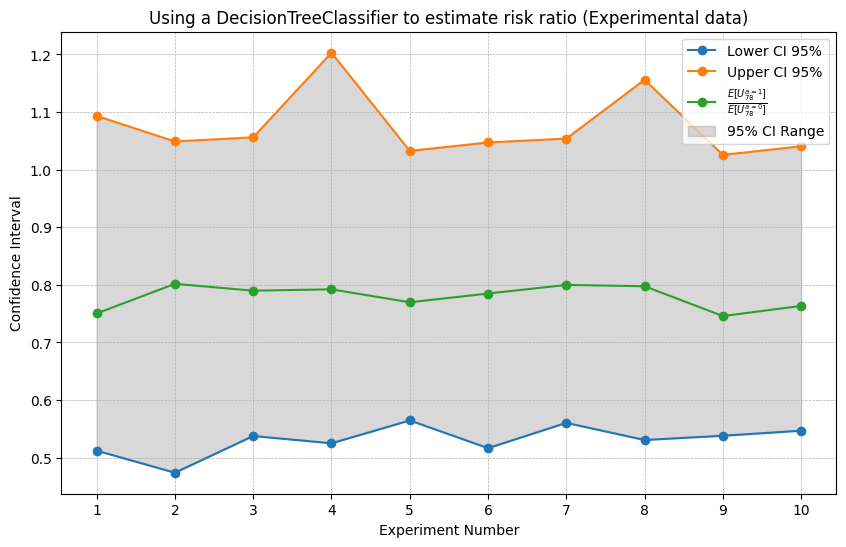

In [9]:
ci_df = pd.DataFrame(
    backdoor_boostrap_results, columns=["mean", "lower_ci", "upper_ci"]
)
ci_df["experiment"] = range(1, len(ci_df) + 1)

plt.figure(figsize=(10, 6))

plt.plot(ci_df["experiment"], ci_df["lower_ci"], label="Lower CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["upper_ci"], label="Upper CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["mean"], label="$\\frac{E[U_{78}^{a=1}]}{E[U_{78}^{a=0}]}$", marker="o")

plt.fill_between(
    ci_df["experiment"],
    ci_df["lower_ci"],
    ci_df["upper_ci"],
    color="gray",
    alpha=0.3,
    label="95% CI Range",
)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(ci_df["experiment"])
plt.xlabel("Experiment Number")
plt.ylabel("Confidence Interval")
plt.title("Using a DecisionTreeClassifier to estimate risk ratio (Experimental data)")
plt.legend()
plt.show()

In [10]:
ci_df

,mean,lower_ci,upper_ci,experiment
0,0.750354,0.512162,1.093324,1
1,0.801804,0.473867,1.048986,2
2,0.789885,0.537612,1.056137,3
3,0.792284,0.524979,1.203012,4
4,0.769741,0.564597,1.032590,5
5,0.784965,0.516536,1.047223,6
6,0.799870,0.560406,1.053934,7
7,0.797583,0.530644,1.156080,8
8,0.745855,0.538062,1.025680,9
9,0.763489,0.546833,1.040571,10


### Observational data

In [11]:
lalonde_obs.loc[lalonde_obs["treat"] == 1, "u78"].mean() / lalonde_obs.loc[
    lalonde_obs["treat"] == 0, "u78"
].mean()

2.117747117747118

In [12]:
backdoor_result = backdoor_classifier(
    lalonde_obs,
    "treat",
    "u78",
    ["age", "education", "black", "hispanic", "married", "u74", "u75"],
    "DecisionTree",
)
print(f"The risk ratio is {backdoor_result:.2f}")

The risk ratio is 1.60


In [13]:
backdoor_boostrap_results = bootstrap_experiment(
    df=lalonde_obs,
    function=backdoor_classifier,
    num_exp=10,
    n=50,
    ci=95,
    treatment_col="treat",
    outcome_col="u78",
    confounder_cols=[
        "age",
        "education",
        "black",
        "hispanic",
        "married",
        "u74",
        "u75",
    ],
    classifier_name="DecisionTree",
)

Running experiments: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.58it/s]


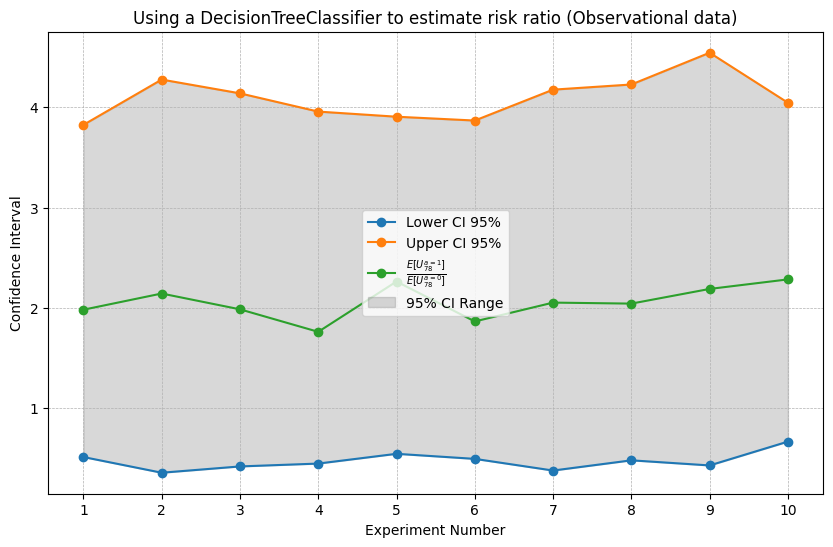

In [14]:
ci_df = pd.DataFrame(
    backdoor_boostrap_results, columns=["mean", "lower_ci", "upper_ci"]
)
ci_df["experiment"] = range(1, len(ci_df) + 1)

plt.figure(figsize=(10, 6))

plt.plot(ci_df["experiment"], ci_df["lower_ci"], label="Lower CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["upper_ci"], label="Upper CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["mean"], label="$\\frac{E[U_{78}^{a=1}]}{E[U_{78}^{a=0}]}$", marker="o")

plt.fill_between(
    ci_df["experiment"],
    ci_df["lower_ci"],
    ci_df["upper_ci"],
    color="gray",
    alpha=0.3,
    label="95% CI Range",
)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(ci_df["experiment"])
plt.xlabel("Experiment Number")
plt.ylabel("Confidence Interval")
plt.title("Using a DecisionTreeClassifier to estimate risk ratio (Observational data)")
plt.legend()
plt.show()

In [15]:
ci_df

,mean,lower_ci,upper_ci,experiment
0,1.982077,0.513053,3.825516,1
1,2.143631,0.356508,4.277378,2
2,1.986066,0.419248,4.140027,3
3,1.761616,0.447767,3.958095,4
4,2.263347,0.545129,3.907007,5
5,1.865053,0.494656,3.868742,6
6,2.053082,0.378216,4.176844,7
7,2.043035,0.480121,4.228264,8
8,2.189470,0.429237,4.545126,9
9,2.284553,0.666884,4.046204,10


* Our estimate is highly biased
* There is no means to compare a change in unemployment from the year 78 to 75.